###Imports

In [62]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
from fastai import *
from fastai.text import *
from fastai.basic_train import load_learner
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
!unzip '/content/drive/My Drive/572515-1037534-compressed-Fake.csv.zip' -o 'Fake.csv'
!unzip "/content/drive/My Drive/572515-1037534-compressed-True.csv.zip" -o 'True.csv'

Archive:  /content/drive/My Drive/572515-1037534-compressed-Fake.csv.zip
  inflating: Fake.csv                
caution: filename not matched:  -o
Archive:  /content/drive/My Drive/572515-1037534-compressed-True.csv.zip
  inflating: True.csv                
caution: filename not matched:  -o


### Preprocessing

In [4]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
df_fake['news_type'] = 'Fake'
df_true['news_type'] = 'True'

In [10]:
df_final = pd.concat([df_fake, df_true])
df_final.reset_index(inplace=True)

In [11]:
df_final_shuffled = df_final.sample(44898, random_state=42,replace=False)
df_final_shuffled.reset_index(inplace=True)

In [13]:
df_final_shuffled.drop(['level_0','index'], axis=1,inplace=True)

In [41]:
df_final_shuffled.head()

,title,text,subject,date,news_type
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",Fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",True
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",True
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",Fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",True


In [17]:
df_final_shuffled.to_csv('df_final_shuffled.csv')

In [16]:
bs = 48
path = '/content/'

### Clickbait Language Model



In [18]:
data_lm_title = (TextList.from_df(df_final_shuffled, path , cols='title')
                .split_by_rand_pct(0.2, seed=42)
                .label_for_lm()
                .databunch(bs=bs, num_workers=1))

In [ ]:
learn_lm_title = language_model_learner(data_lm_title, AWD_LSTM)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


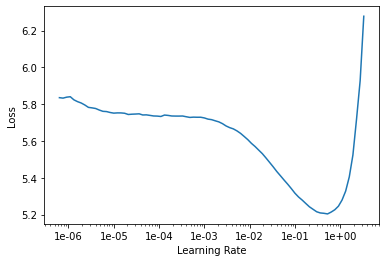

In [ ]:
learn_lm_title.lr_find()
learn_lm_title.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn_lm_title.unfreeze()
learn_lm_title.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.462937,3.112184,0.461670,00:50
1,3.141155,2.968802,0.470031,00:52
2,3.055329,2.934116,0.473949,00:52
3,2.945087,2.880423,0.480871,00:52
4,2.811364,2.817964,0.488614,00:52
5,2.660631,2.754498,0.496199,00:52
6,2.452157,2.684139,0.507418,00:52
7,2.276055,2.638280,0.517478,00:52
8,2.122625,2.620090,0.522006,00:52
9,2.048713,2.620610,0.522935,00:52


In [ ]:
learn_lm_title.save('/content/drive/My Drive/Fake News/title_finetuned')
learn_lm_title.save_encoder('/content/drive/My Drive/Fake News/title_finetuned_enc')

In [ ]:
learn_lm_title.predict('Donald Trump', n_words = 25)

'Donald Trump Once Again Makes Us $ 68 MILLION To Former Russia Negotiator On Twitter'

### Semantic Language Model

In [50]:
data_lm_news = (TextList.from_df(df_final_shuffled, path , cols='text')
                .split_by_rand_pct(0.2, seed=42)
                .label_for_lm()
                .databunch(bs=bs, num_workers=1))

In [ ]:
learn_lm_news = language_model_learner(data_lm_news, AWD_LSTM)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


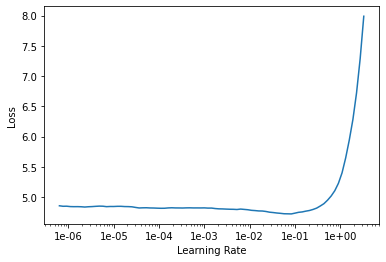

In [ ]:
learn_lm_news.lr_find()
learn_lm_news.recorder.plot()

In [ ]:
learn_lm_news.fit_one_cycle(1, lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.031266,3.619655,0.347773,31:38


In [ ]:
learn_lm_news.predict('Donald Trump', n_words=65)

'Donald Trump leader , Donald Trump , said in a speech at the White House that he is at the bottom line with Donald Trump and the Democrat Party that aren t highlighting his campaign . Neighbor Rogers , White House spokesman Sean Spicer said he believes deal underlined whatever the world don'

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


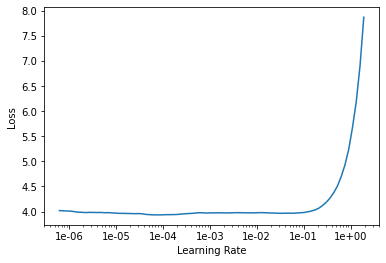

In [ ]:
learn_lm_news.lr_find()
learn_lm_news.recorder.plot()

In [ ]:
learn_lm_news.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.135810,3.742503,0.335516,31:39
1,3.953421,3.572860,0.351748,31:40


In [ ]:
learn_lm_news.save('/content/drive/My Drive/Fake News/news_finetuned')
learn_lm_news.save_encoder('/content/drive/My Drive/Fake News/news_finetuned_enc')

### Clickbait Classifier 

In [19]:
data_title_clas = (TextList.from_df(df_final_shuffled,path,vocab=data_lm_title.vocab,cols='title')
                  .split_by_rand_pct(0.2,seed=42)
                  .label_from_df('news_type')
                  .databunch(bs=bs, num_workers=1))

In [20]:
data_title_clas.save(f'{path}/title_textlist_clas')

In [22]:
@np_func
def f1(inp, targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [23]:
data_title_clas = load_data(path, 'title_textlist_clas', bs=bs, num_workers=1)

In [24]:
learn_title_cl = text_classifier_learner(data_title_clas, AWD_LSTM, metrics=[accuracy, f1])
learn_title_cl.load_encoder(f'/content/drive/My Drive/Fake News/title_finetuned_enc')
learn_title_cl.freeze()

epoch,train_loss,valid_loss,accuracy,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


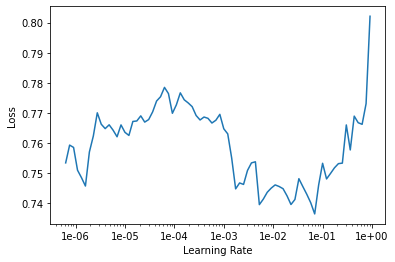

In [25]:
learn_title_cl.lr_find()
learn_title_cl.recorder.plot()

In [26]:
lr = 1e-2
learn_title_cl.unfreeze()
learn_title_cl.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.335455,0.010173,0.998886,0.608419,00:55
1,0.295095,0.009594,0.998552,0.607737,00:57
2,0.570317,0.611237,0.561867,0.168344,01:03
3,0.527064,0.759487,0.541486,0.033532,01:02
4,0.569085,0.870012,0.522219,0.003629,01:02
5,0.623758,0.609264,0.565208,0.075866,00:55
6,0.560622,0.369168,0.912462,0.518132,01:02
7,0.524624,0.266462,0.962357,0.555159,00:59
8,0.507264,0.276018,0.950551,0.538062,01:02
9,0.530402,0.319021,0.947767,0.526929,01:01


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

**[Fake, True]**

In [51]:
learn_title_cl.export('/content/drive/My Drive/Fake News/title_classifier.pkl')

In [52]:
learn_title_cl.save('/content/drive/My Drive/Fake News/title_classifier')

### News Classifier

In [53]:
data_news_clas = (TextList.from_df(df_final_shuffled,path,vocab=data_lm_news.vocab,cols='text')
                  .split_by_rand_pct(0.2,seed=42)
                  .label_from_df('news_type')
                  .databunch(bs=bs, num_workers=1))

In [55]:
learn_news_cl = text_classifier_learner(data_news_clas, AWD_LSTM,metrics=[accuracy,f1])
learn_news_cl.load_encoder('/content/drive/My Drive/Fake News/news_finetuned_enc')
learn_news_cl.freeze()

epoch,train_loss,valid_loss,accuracy,f1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


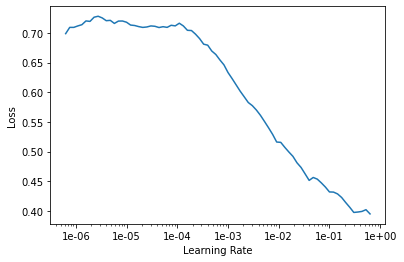

In [56]:
learn_news_cl.lr_find()
learn_news_cl.recorder.plot()

In [58]:
lr = 1e-4

In [59]:
learn_news_cl.fit_one_cycle(5,lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.224404,0.131024,0.958793,0.923282,08:07
1,0.210221,0.083813,0.973716,0.940512,08:32
2,0.141855,0.081374,0.966255,0.949296,07:57
3,0.151285,0.064323,0.979508,0.951874,09:18
4,0.141710,0.096084,0.970375,0.939876,09:09


In [61]:
learn_news_cl.export('/content/drive/My Drive/Fake News/news_classifier.pkl')
learn_news_cl.save('/content/drive/My Drive/Fake News/news_classifier')

In [66]:
learn_news_cl.data.c

2

In [70]:
preds, targs = learn_title_cl.get_preds(ordered=True)
accuracy(preds,targs), f1(preds, targs)

(tensor(0.9478), tensor(0.9421, dtype=torch.float64))

In [71]:
preds_a, targs_a = learn_news_cl.get_preds(ordered=True)
accuracy(preds_a,targs_a), f1(preds_a, targs_a)

(tensor(0.9704), tensor(0.9696, dtype=torch.float64))

In [72]:
preds_avg = (preds+preds_a)/2
accuracy(preds_avg,targs), f1(preds_avg,targs)

(tensor(0.9920), tensor(0.9916, dtype=torch.float64))